# WIMU-SIWY Prototyp
### Autorzy: Bartosz Han, Bartosz Kisły, Igor Matynia


W ramach prototypu, udało nam się stworzyć forka repozytorium zawierające kod źródłowy TRAKa, a także uruchomić tą metodę atrybucji danych na przykładowym zadaniu klasyfikacji obrazów. Ten notatnik zawiera przykład uruchomienia TRAKa na modelu sztucznej inteligencji - uruchomiliśmy TRAK na pretrenowanym modelu ResNet18, w celu wykonania atrybucji na części zbioru danych CIFAR100.

W trakcie tworzenia prototypu, próbowaliśmy przeprowadzić testową atrybucję danych muzycznych. Nie udało nam się jednak przeprowadzić tego eksperymentu - wymagana jest głębsza analiza kodu źródłowego TRAKa.

In [11]:
# Przed uruchomieniem notatnika należy pobrać biblioteki znajdujące się w requirements.txt
# Importowanie bibliotek
import torch
from trak import TRAKer
from torchvision import transforms
from torchvision import models
from torchvision import datasets
import matplotlib.pyplot as plt

In [12]:
# Tworzenie modelu
torch.manual_seed(42)
model = models.resnet18()
checkpoint = model.state_dict()
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Pobieranie i tworzenie datasetów
X_train = datasets.CIFAR100("CIFAR100", download=True, train=True, transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]))
X_train = torch.utils.data.Subset(X_train, list(range(128)))

X_test = datasets.CIFAR100("CIFAR100", download=True, train=False, transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]))
X_test = torch.utils.data.Subset(X_test, list(range(64)))


train_loader = torch.utils.data.DataLoader(
    X_train,
    batch_size=64,
    shuffle=True,
    pin_memory=(device == "cuda"),
    num_workers=(4 if device == "cuda" else 0))

targets_loader = torch.utils.data.DataLoader(
    X_test,
    batch_size=64,
    shuffle=True,
    pin_memory=(device == "cuda"),
    num_workers=(4 if device == "cuda" else 0))



INFO:STORE:Existing model IDs in /home/bartosz/Projects/trak/trak_results: [0]
INFO:STORE:Model IDs that have been finalized: [0]
INFO:STORE:Existing TRAK scores:
INFO:STORE:quickstart: /home/bartosz/Projects/trak/trak_results/scores/quickstart.mmap


Batch [1/2] Completed
Batch [2/2] Completed


Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00, 752.21it/s]


Batch [1/1] Completed


Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00, 108.20it/s]
INFO:STORE:Saving scores in /home/bartosz/Projects/trak/trak_results/scores/quickstart.mmap


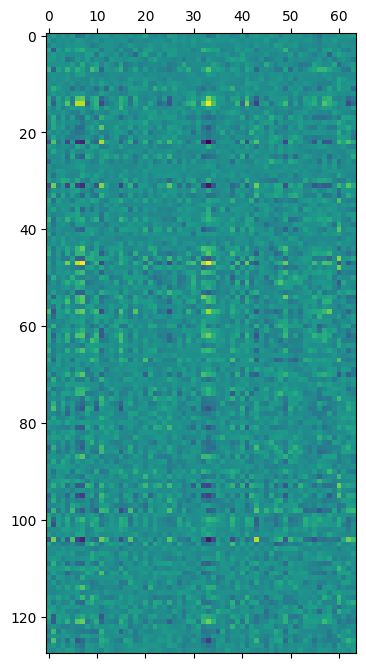

In [14]:
# Inicjalizacja i uruchomienie TRAKa

traker = TRAKer(model=model, task='image_classification', train_set_size=len(X_train))

i=1
traker.load_checkpoint(checkpoint, model_id=0)
for X, y in train_loader:
    X = X.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)
    traker.featurize(batch=(X, y), num_samples=X.shape[0])
    print(f"Batch [{i}/{len(train_loader)}] Completed")
    i+=1
traker.finalize_features()

traker.start_scoring_checkpoint('quickstart', checkpoint, model_id=0, num_targets=len(X_test))

i=1
for X, y in targets_loader:
    X = X.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)
    traker.score(batch=(X, y), num_samples=X.shape[0])
    print(f"Batch [{i}/{len(targets_loader)}] Completed")
    i+=1

scores = traker.finalize_scores(exp_name='quickstart')
plot = plt.matshow(scores)


Na powyższym wykresie przedstawiony jest wpływ danych treningowych (oś Y) na predykcję danych testowych (oś X).